In [1]:
import torch
import numpy as np
import time
np.random.seed(0)
torch.manual_seed(0)

## Testing BatchedKmeans with data from Normal(0, 1) and Normal(10, 1)

In [68]:
###
# Kmeans Code
###
def batched_distance_matrix(x,y):
    """
    Batched L2 Norm

    Parameters
    ----------
    x : Tensor of shape (Batch_Size , A, Feature_Dimension) 
    y : Tensor of shape (Batch_Size , B, Feature_Dimension) 

    Returns
    -------
    D_ij : torch.Tensor of shape (Batch_Size , A, B )
    """
    N,A,D = x.shape
    _,B,D = y.shape
    x_i = x.view(N,A, 1, D)
    y_j = y.view(N,1,B,D)
    D_ij = ((x_i - y_j) ** 2).sum(-1)
    return D_ij

def k_means_pp_batched(x, n_clusters):
    """
    K-Means++ initialization

    Based on Scikit-Learn's implementation

    Parameters
    ----------
    x : torch.Tensor of shape (n_training_samples, n_features)
    n_clusters : int

    Returns
    -------
    centroids : torch.Tensor of shape (n_clusters, n_features)
    """

    n_batch,n_samples, n_features = x.shape

    centroids = torch.zeros((n_batch,n_clusters, n_features), dtype=x.dtype, device=x.device)

    n_local_trials = 2 + int(np.log(n_clusters))

    initial_centroid_idx = torch.randint(low=0, high=n_samples, size=(n_batch,), device=x.device)
    batch_eye =  torch.eye(n_batch, dtype=x.dtype, device=x.device)[...,None] # B X B X 1
    centroids[:,0, :] = torch.diagonal( x[:,initial_centroid_idx]).T #equivalent to (batch_eye * torch.index_select(x,1,initial_centroid_idx)).sum(dim=1)

    # dist_mat = distance_matrix(x=centroids[0, :].unsqueeze(0), y=x,
    #                            x_norm=x_norm[initial_centroid_idx, :].unsqueeze(0), y_norm=x_norm) # 1 X N
    dist_mat = batched_distance_matrix(centroids[:,0:1, :],x)
    #current_potential = dist_mat.sum(1) # 1
    current_potential = dist_mat.sum(-1) # n_batch X 1
    #print(n_clusters)
    for c in range(1, n_clusters):
        rand_vals = torch.rand(n_batch,n_local_trials, device=x.device) * current_potential # n_local_trials * (n_batch X 1)->  n_batch * n_local_trials
        candidate_ids = torch.searchsorted(torch.cumsum(dist_mat.squeeze(1), dim=-1), rand_vals)
        torch.clamp_max(candidate_ids, dist_mat.size(-1) - 1, out=candidate_ids)

        # distance_to_candidates = distance_matrix(x=x[candidate_ids, :], y=x,
        #                                          x_norm=x_norm[candidate_ids, :], y_norm=x_norm)

        # _x_ii =torch.einsum('bxyd,bx->bxyd',x[:,candidate_ids,:],batch_eye.squeeze(-1)).sum(dim=1) # x[:,candidate_ids,:]-> B X B X n_local_trials X DIM
        _x_ii = torch.diagonal( x[:,candidate_ids]).permute(2,0,1)
        distance_to_candidates = batched_distance_matrix(_x_ii,x)

        distance_to_candidates = torch.where(dist_mat < distance_to_candidates, dist_mat, distance_to_candidates)
        candidates_potential = distance_to_candidates.sum(-1)

        best_candidate = candidates_potential.argmin(-1)
        #breakpoint()
        current_potential = candidates_potential[:,best_candidate].diag().view(n_batch,1)
        #breakpoint()
        #dist_mat = distance_to_candidates[best_candidate].unsqueeze(0) # 1 X N
        dist_mat = torch.diagonal(distance_to_candidates[:,best_candidate],dim1=0,dim2=1).T.unsqueeze(1) # B X N
        best_candidate = candidate_ids[:,best_candidate].diag()

        #centroids[c, :] = x[best_candidate, :]
        centroids[:,c, :] = torch.diagonal( x[:,best_candidate]).T
    return centroids

def do_batch_kmeans(x, K=10, Niter=10,init='K-means++',eps=1e-6):
    """Implements Lloyd's algorithm for the Euclidean metric.

    Parameters
    ----------
    x : torch.Tensor of shape (Batch_Size,Samples_per_Batch, n_features)
    init : string, Initialization method, defualt to 'K-means++', and alternative input are considered as taking first K elements as initial centroid in each batch
    eps: float, threshold for termination
    Returns
    -------
    cl : torch.Tensor of shape (Batch_Size,Samples_per_Batch), Cluster Assignment as Long Tensor
    c : torch.Tensor of shape (Batch_Size,K, n_features), Centroids
    """

    start = time.time()
    N,B, D = x.shape  # Batch_Size X Samples per Batch X Dim
    if init == 'K-means++':
        c = k_means_pp_batched(x,K)
    else:
        c = x[:,:K, :].clone()  # Simplistic initialization for the centroids

    x_i = x.view(N,B, 1, D)  # (N, 1, D) samples
    c_j = c.view(N,1, K, D) # (1, K, D) centroids
    Ncl = torch.zeros(N,K,1, dtype=x.dtype, device=x.device)
    _ones = torch.ones(N,B,1, dtype=x.dtype, device=x.device)
    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1,keepdim=True)  # (N,B,K) symbolic squared distances
        cl = D_ij.argmin(dim=2).long()  # Points -> Nearest cluster
        inertia = D_ij.min(dim=2,keepdim=True).values.sum() #torch.sum(D_ij.min(dim=-1))
        #breakpoint()
        if abs(inertia) < eps:
                # self.labels_ = labels
                # self.inertia_ = inertia
                # break
                return cl,inertia
        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(1, cl.repeat(1,1, D), x)
        # Divide by the number of points per cluster:
        #Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        Ncl.zero_()
        Ncl.scatter_add_(1, cl,_ones)
        c /= Ncl  # in-place division to compute the average

    # if verbose:  # Fancy display -----------------------------------------------
    #     if use_cuda:
    #         torch.cuda.synchronize()
    #     end = time.time()
    #     print(
    #         f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
    #     )
    #     print(
    #         "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
    #             Niter, end - start, Niter, (end - start) / Niter
    #         )
    #     )

    return cl.view(N,B), c

class BatchwiseKMeans:

    def __init__(self,n_kmeans=10, Niter=200,init='K-means++',eps=1e-6):
        self.n_kmeans = n_kmeans
        self.Niter = Niter
        self.init = init
        self.eps = eps

    def fit_transform(self,x):
        assert len(x.shape) == 3
        return do_batch_kmeans(x, K=self.n_kmeans, Niter=self.Niter,init=self.init,eps=self.eps)


In [69]:
def test_clustering(kmeans, k=2):
    if k != 2:
        raise NotImplementedError()

    d1 = torch.distributions.normal.Normal(0, 1, validate_args=None) #0, 1 gaussian
    d2 = torch.distributions.normal.Normal(10,1,validate_args=None) #10,1 gaussian

    # Get samples
    x1 = d1.sample((25,)).unsqueeze(-1) # Samples from N(0,1)
    x2 = d2.sample((25,)).unsqueeze(-1) #Samples from N(10,1)
    X = torch.stack([x1, x2]) #All samples

    # Kmeans Cluster
    labels, centroids = kmeans.fit_transform(X)

    # Evaluate cluster accuracy
    gt1 = torch.stack([torch.tensor([0]*25), torch.tensor([1]*25)])
    gt2 = torch.stack([torch.tensor([1]*25), torch.tensor([0]*25)])
    acc = max((labels == gt1).sum(), (labels == gt2).sum()) / torch.numel(labels)
    #print(f"Accuracy {acc*100}%")
    return acc * 100

In [71]:
K = 2
kmeans = BatchwiseKMeans(K)

In [73]:
#accs

In [74]:
T = 100
accs = []
for _ in range(T):
    accs.append(test_clustering(kmeans, K))

print("BatchedKmeans Average Accuracy")
print(sum(accs) / len(accs))
print(accs)

BatchedKmeans Average Accuracy
tensor(58.2600)
[tensor(58.), tensor(50.), tensor(56.), tensor(74.), tensor(58.), tensor(54.0000), tensor(58.), tensor(50.), tensor(54.0000), tensor(68.), tensor(58.), tensor(62.), tensor(58.), tensor(58.), tensor(56.), tensor(50.), tensor(64.), tensor(54.0000), tensor(58.), tensor(52.), tensor(62.), tensor(52.), tensor(54.0000), tensor(52.), tensor(64.), tensor(54.0000), tensor(64.), tensor(50.), tensor(56.), tensor(52.), tensor(64.), tensor(60.0000), tensor(62.), tensor(64.), tensor(76.), tensor(58.), tensor(72.), tensor(50.), tensor(64.), tensor(56.), tensor(54.0000), tensor(50.), tensor(52.), tensor(58.), tensor(52.), tensor(62.), tensor(58.), tensor(66.), tensor(56.), tensor(58.), tensor(56.), tensor(56.), tensor(50.), tensor(62.), tensor(52.), tensor(72.), tensor(56.), tensor(54.0000), tensor(56.), tensor(58.), tensor(64.), tensor(50.), tensor(68.), tensor(60.0000), tensor(50.), tensor(56.), tensor(70.), tensor(52.), tensor(50.), tensor(56.), tensor

## Testing Scikit-Learn Kmeans with Same 2 Distributions

In [99]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


In [100]:
kmean_sklearn = KMeans(K, n_init=1, max_iter=200, tol=1e-6, random_state=0)
accs = []
for _ in range(T):
    x1_np = np.random.normal(0,1,25)
    x2_np = np.random.normal(10, 1, 25)
    X_np = np.concatenate([x1_np, x2_np]).reshape(-1, 1)

    kmeans_output = kmean_sklearn.fit(X_np)
    pred = kmeans_output.labels_
    acc = max(accuracy_score(np.array([0]*25  + [1]*25), pred), accuracy_score(np.array([1]*25 + [0] * 25), pred))
    accs.append(acc  * 100)

print("SKLEARN KMeans (same hp) Avg Acc")
print(sum(accs) / len(accs))

SKLEARN KMeans (same hp) Avg Acc
100.0


In [144]:
X_np = []
for _ in range(T):
    x1_np = np.random.multivariate_normal([0,0],np.diag([1,1]),25)
    x2_np = np.random.multivariate_normal([10,10],np.diag([1,1]), 25)
    Xi_np = np.concatenate([x1_np, x2_np]).reshape(-1, 2)
    X_np.append(Xi_np)
X_np = np.stack(X_np)
pred_torch,pred_torch_center = kmeans.fit_transform(torch.Tensor(X_np))
pred_torch = pred_torch.numpy()
pred_np = []
for i in range(T):
    kmeans_output = kmean_sklearn.fit(X_np[i])
    pred = kmeans_output.labels_
    pred_np.append(pred)
pred_np = np.stack(pred_np)
def acc_score_fixed(src,tgt):
    return np.mean(src==tgt)
accs_torch = []
accs_np = []
for i in range(T):
    pred_torch_i = pred_torch[i]
    acc_torch_i = max(acc_score_fixed(np.array([0]*25  + [1]*25), pred_torch_i), acc_score_fixed(np.array([1]*25 + [0] * 25), pred_torch_i))
    accs_torch.append(acc_torch_i)
    pred_np_i = pred_np[i]
    acc_np_i = max(acc_score_fixed(np.array([0]*25  + [1]*25), pred_np_i), acc_score_fixed(np.array([1]*25 + [0] * 25), pred_np_i))
    accs_np.append(acc_np_i)
print("ACC TORCH",np.mean(accs_torch),"ACC NP",np.mean(accs_np))

ACC TORCH 1.0 ACC NP 1.0


In [166]:
from matplotlib import pyplot as plt

In [167]:
X_np = []
labels = []
base_indice = np.array([0]*25  + [1]*25)
for _ in range(T):
    x1_np = np.random.multivariate_normal([0,0],np.diag([1,1]),25)
    x2_np = np.random.multivariate_normal([10,10],np.diag([1,1]), 25)
    Xi_np = np.concatenate([x1_np, x2_np]).reshape(-1, 2)
    arr_idx = np.arange(50)
    np.random.shuffle(arr_idx)
    Xi_np = Xi_np[arr_idx]
    X_np.append(Xi_np)
    labels.append(base_indice[arr_idx])
X_np = np.stack(X_np)
pred_torch,pred_torch_center = kmeans.fit_transform(torch.Tensor(X_np))
pred_torch = pred_torch.numpy()
pred_np = []
for i in range(T):
    kmeans_output = kmean_sklearn.fit(X_np[i])
    pred = kmeans_output.labels_
    pred_np.append(pred)
pred_np = np.stack(pred_np)
def acc_score_fixed(src,tgt):
    return np.mean(src==tgt)
accs_torch = []
accs_np = []
for i in range(T):
    pred_torch_i = pred_torch[i]
    acc_torch_i = max(acc_score_fixed(labels[i], pred_torch_i), acc_score_fixed(1-labels[i], pred_torch_i))
    accs_torch.append(acc_torch_i)
    pred_np_i = pred_np[i]
    acc_np_i = max(acc_score_fixed(labels[i], pred_np_i), acc_score_fixed(1-labels[i], pred_np_i))
    accs_np.append(acc_np_i)
print("ACC TORCH",np.mean(accs_torch),"ACC NP",np.mean(accs_np))

ACC TORCH 1.0 ACC NP 1.0


In [182]:
print('Sanity Check: Are all torch predictions equals np prediction in terms of label idx?\n{}'.format(np.all(pred_torch == pred_np)))

Sanity Check: Are all torch predictions equals np prediction in terms of label idx?
False


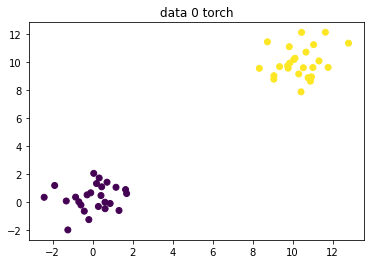

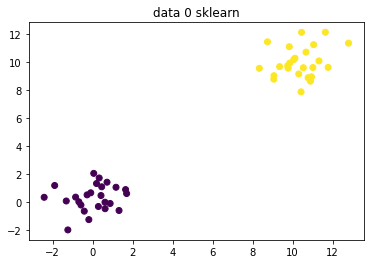

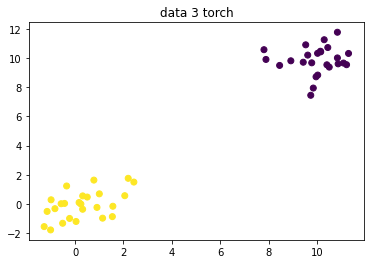

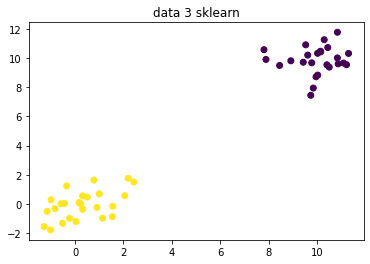

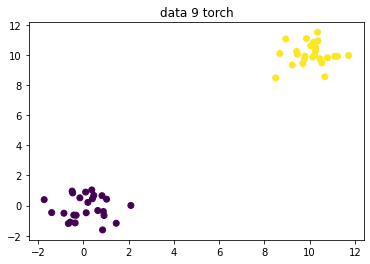

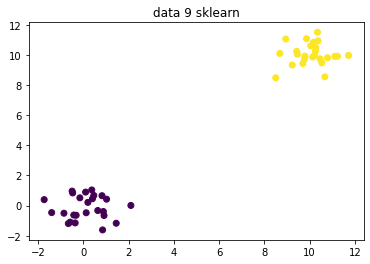

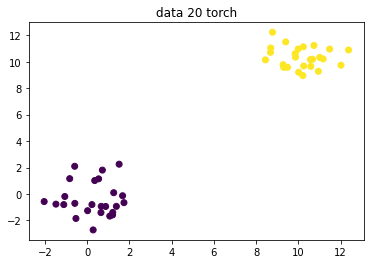

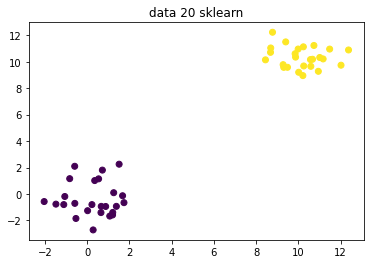

In [175]:
visualization_data_indices = [0,3,9,20]
for idx in visualization_data_indices:
    X = X_np[idx]
    plt.figure()
    plt.title(f'data {idx} torch')
    plt.scatter(X[:,0],X[:,1],c=pred_torch[idx])
    plt.figure()
    plt.title(f'data {idx} sklearn')
    plt.scatter(X[:,0],X[:,1],c=pred_np[idx])